In [ ]:
import yfinance as yf
import pandas as pd
import plotly.express as px

# Define the tickers
tickers = {
    'NVIDIA': 'NVDA',
}

""" tickers = {
    'SPY': 'SPY',        # SPDR S&P 500 ETF Trust
    'Apple': 'AAPL',     # Apple Inc.
    'NVIDIA': 'NVDA',    # NVIDIA Corporation
    'Tesla': 'TSLA',     # Tesla Inc.
    'Bitcoin': 'btc-USD', # Bitcoin
    # Additional popular tickers
    'Amazon': 'AMZN',    # Amazon.com, Inc.
    'Google': 'GOOGL',   # Alphabet Inc. (Class A)
    'Microsoft': 'MSFT', # Microsoft Corporation
    'Meta': 'META',      # Meta Platforms, Inc.
} """

# Download historical data for the tickers
data = yf.download(
    tickers=list(tickers.values()),
    period='max',       # Adjust the period as needed # Adjust the period as needed '6mo' '1d' 'max'
    interval='1h',     # Data interval Data interval '1m' '1h' '1d'       #best is w max and 1d so far 
    group_by='ticker',
    auto_adjust=True,
    threads=True
)

print(data)

btc = data

btc.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in btc.columns]
ticker_prefix = btc.columns[0].split('_')[0]

# Renaming the columns to remove prefixes and simplify names
new_column_names = {
    f'{ticker_prefix}_Open': 'Open',
    f'{ticker_prefix}_High': 'High',
    f'{ticker_prefix}_Low': 'Low',
    f'{ticker_prefix}_Close': 'Close',
    f'{ticker_prefix}_Volume': 'Volume'
}
btc.rename(columns=new_column_names, inplace=True)

btc.reset_index(inplace=True)

print(btc)

# Step 1: Extract Bitcoin Volume before dropping columns
print(btc['Volume'].eq(0).sum())
print(btc)
print(btc.describe())
# Count NaNs in each column
na_counts = btc.isna().sum()

# Display the count of NaNs for each column
print(na_counts)


[*********************100%***********************]  1 of 1 completed

Ticker                           NVDA                                      \
Price                            Open        High         Low       Close   
Date                                                                        
1999-01-22 00:00:00+00:00    0.040122    0.044779    0.035585    0.037615   
1999-01-25 00:00:00+00:00    0.040600    0.042033    0.037615    0.041556   
1999-01-26 00:00:00+00:00    0.042033    0.042869    0.037734    0.038331   
1999-01-27 00:00:00+00:00    0.038451    0.039406    0.036301    0.038212   
1999-01-28 00:00:00+00:00    0.038212    0.038451    0.037854    0.038092   
...                               ...         ...         ...         ...   
2024-12-04 00:00:00+00:00  141.990222  145.779954  140.280333  145.130005   
2024-12-05 00:00:00+00:00  145.110001  146.539993  143.949997  145.059998   
2024-12-06 00:00:00+00:00  144.600006  145.699997  141.309998  142.440002   
2024-12-09 00:00:00+00:00  138.970001  139.949997  137.130005  138.809998   

In [ ]:
if 'Datetime' in btc.columns:
    btc.rename(columns={'Datetime': 'Date'}, inplace=True)
    btc = btc.drop(columns="Volume")

print(btc)

# Perform min-max normalization for each asset
normalized_prices = btc.copy() #closed_prices, crypto_df, non_crypto_df, btc, compiled

# Exclude the 'Date' column during normalization
for col in normalized_prices.columns[1:]:
    min_price = normalized_prices[col].min()
    max_price = normalized_prices[col].max()
    normalized_prices[col] = ((normalized_prices[col] - min_price) / (max_price - min_price)) * 100

# Melt the DataFrame to long format
normalized_prices_melted = normalized_prices.melt(id_vars='Date', var_name='Asset', value_name='Normalized Price')

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each asset's normalized prices
for asset, data in normalized_prices_melted.groupby('Asset'):
    ax.plot(data['Date'], data['Normalized Price'], label=asset)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price (0% = Min, 100% = Max)')
ax.set_title('Min-Max Normalized Closing Prices for Selected Assets Over Time')
ax.legend()

# Show the plot
plt.show()

print(btc)

In [3]:
import pandas as pd
import os

def clean_sentiment_score(score):
    """Remove leading single quote from sentiment score if present"""
    if isinstance(score, str) and score.startswith("'"):
        return float(score.lstrip("'"))
    return float(score)

# Read the sentiment file
file_path = os.path.join(os.path.expanduser('~'), 'Downloads', 'combined_crypto_analysis.csv')
sentiment_df = pd.read_csv(file_path)

# Process and merge the data
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.tz_localize('UTC')
sentiment_df['sentiment_score'] = sentiment_df['avg_sentiment'].apply(clean_sentiment_score)
btc['Date'] = pd.to_datetime(btc['Date'])

# Merge and update btc DataFrame
btc = btc.merge(sentiment_df[['Date', 'sentiment_score']], on='Date', how='left')

print(f"Merged shape: {btc.shape}, Rows with sentiment: {btc['sentiment_score'].notna().sum()}")

Merged shape: (6514, 7), Rows with sentiment: 2569


btc
            Open        High         Low     Close     Volume  \
0       0.456251    0.461987    0.454100  0.052230  173584000   
1       0.460553    0.465094    0.459119  1.514367  219604000   
2       0.466050    0.466528    0.455295 -1.851854  601316000   
3       0.465333    0.465333    0.450993 -0.995815  221464000   
4       0.449081    0.454578    0.447408 -0.423510  196144000   
...          ...         ...         ...       ...        ...   
2564  145.919938  147.149864  141.090284 -3.218113  236406200   
2565  141.980225  142.040219  135.810652 -4.177520  344941900   
2566  137.690513  139.290409  135.660654  0.661664  190287700   
2567  135.000694  137.210549  131.790924 -1.153961  226370900   
2568  136.770579  139.340409  136.040633  2.150145  141863200   

      sentiment_score  Close_True  
0           -1.948052    0.457685  
1           -2.274216    0.464616  
2           -1.657459    0.456012  
3           -2.158273    0.451471  
4           -2.544529    0.449559  

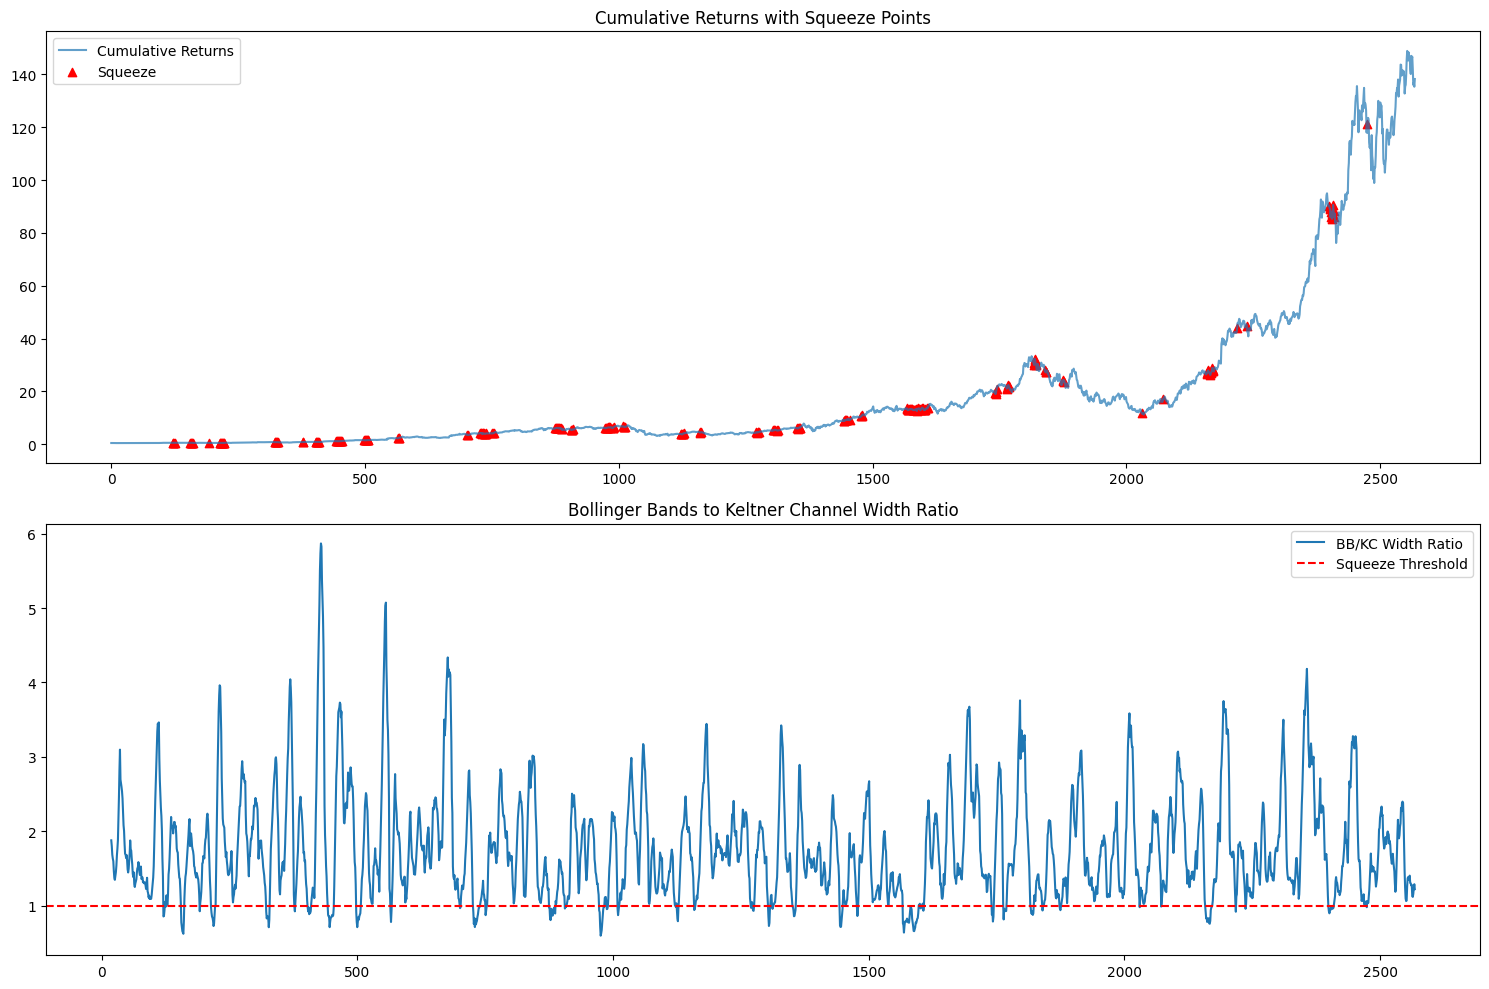

count    2550.000000
mean        4.186885
std         7.391085
min         0.023115
25%         0.419576
50%         1.122342
75%         4.640441
max        47.595002
Name: BB_width, dtype: float64
count    2550.000000
mean        2.395822
std         4.029920
min         0.028605
25%         0.315511
50%         0.715838
75%         2.511106
max        25.657421
Name: KC_width, dtype: float64
count    2550.000000
mean        1.771988
std         0.722831
min         0.594970
25%         1.249607
50%         1.624531
75%         2.139000
max         5.868480
Name: BB_KC_ratio, dtype: float64
First few values of cumulative_returns:
2564    141.940216
2565    136.010635
2566    136.910568
2567    135.330673
2568    138.240479
Name: Close_True, dtype: float64
First few values of cumulative_high:
2564    147.149864
2565    142.040219
2566    139.290409
2567    137.210549
2568    139.340409
Name: High, dtype: float64
First few values of cumulative_low:
2564    141.090284
2565    135.810652

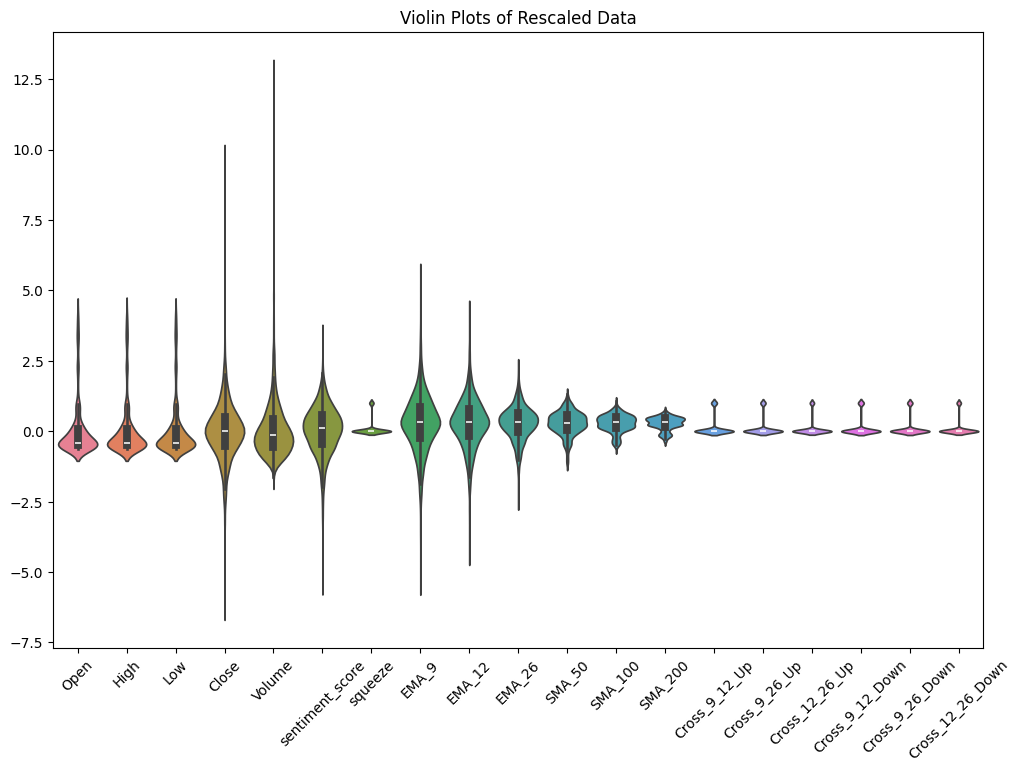

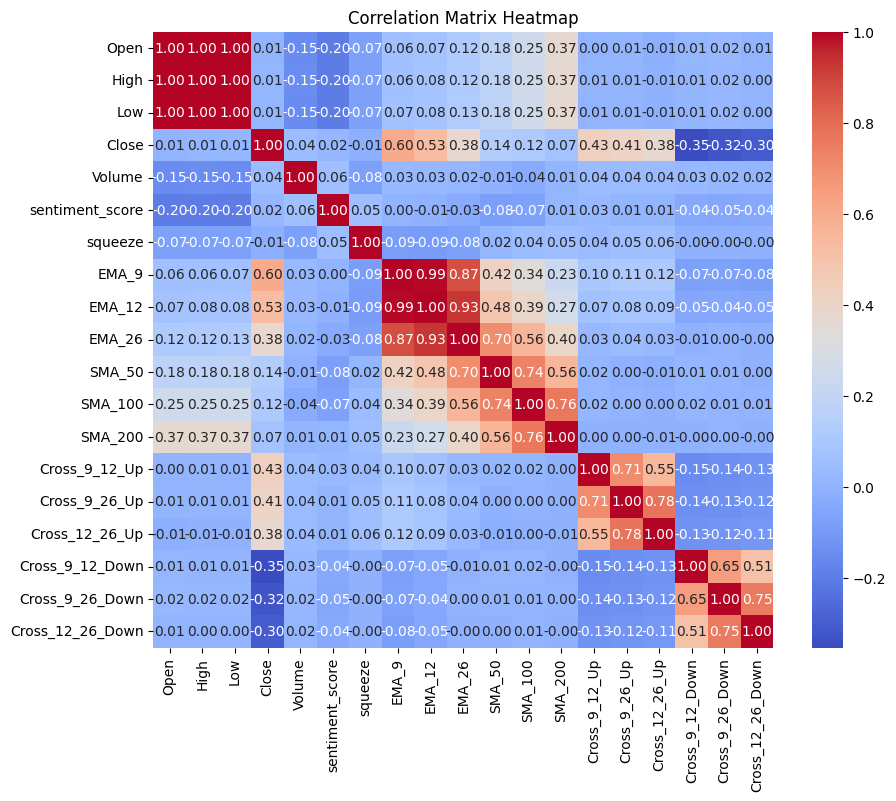

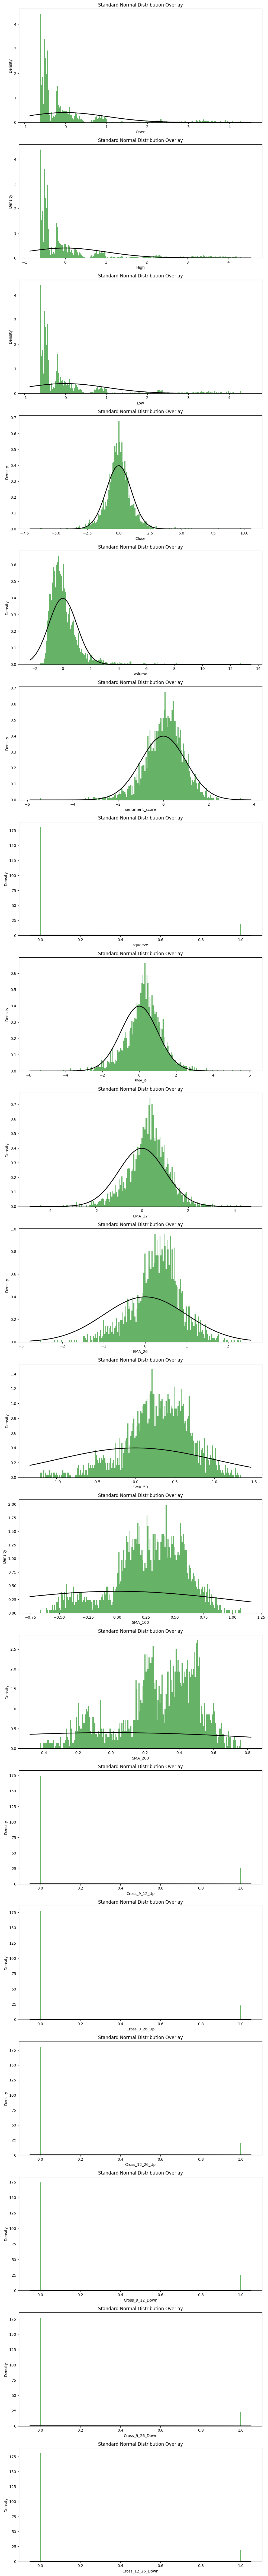

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Converts Close to Percentage ################################################################################
btc["Close_True"] = btc['Close']
btc['Close'] = btc['Close'].pct_change() * 100
btc = btc.dropna().reset_index(drop=True)

def global_rescale(data):
    mean_val = np.mean(data)
    std_val = np.std(data)
    # Avoid division by zero if data has zero variance
    if std_val == 0:
        rescaled_data = np.zeros_like(data)
    else:
        rescaled_data = (data - mean_val) / std_val
    return rescaled_data

if 'Date' in btc.columns:
    btc = btc.drop(columns='Date')
# Apply the global_rescale function to each column
rescaled_data = btc.apply(global_rescale) #Compiled, use 'data' hear to implement hgih and low prices but must realize this df is lvl1 and lvl 0 # Also use 'btc' for strictly bitcoin

print("btc")
print(btc)
print("rescaled_data")
print(rescaled_data)

# Calculate EMA for ATR
def calculate_ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

# Parameters
bb_length = 20
bb_std_dev = 2
kc_length = 20
kc_multiplier = 1.5

# Convert percentage changes back to price-like series for calculations
cumulative_returns = btc['Close_True']
cumulative_high = btc['High']
cumulative_low = btc['Low']

# Calculate Bollinger Bands on the cumulative series
sma = cumulative_returns.rolling(window=bb_length).mean()
std = cumulative_returns.rolling(window=bb_length).std()
bb_upper = sma + (bb_std_dev * std)
bb_lower = sma - (bb_std_dev * std)

# Calculate True Range using cumulative values
tr1 = cumulative_high - cumulative_low
tr2 = abs(cumulative_high - cumulative_returns.shift(1))
tr3 = abs(cumulative_low - cumulative_returns.shift(1))
true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

# Calculate ATR using EMA
atr = calculate_ema(true_range, kc_length)

# Calculate Keltner Channels
kc_upper = sma + (kc_multiplier * atr)
kc_lower = sma - (kc_multiplier * atr)

# Calculate TTM Squeeze
squeeze = np.where(
    (bb_upper < kc_upper) & (bb_lower > kc_lower),
    1,  # Squeeze is on
    0   # Squeeze is off
)

# Calculate Momentum
highest_high = cumulative_high.rolling(window=bb_length).max()
lowest_low = cumulative_low.rolling(window=bb_length).min()
avg_hl = (highest_high + lowest_low) / 2
avg_hlc = (avg_hl + cumulative_returns) / 2
momentum = cumulative_returns - avg_hlc

# Store calculations
btc['squeeze'] = squeeze
rescaled_data['squeeze'] = squeeze
btc['momentum'] = momentum
btc['BB_upper'] = bb_upper
btc['BB_lower'] = bb_lower
btc['KC_upper'] = kc_upper
btc['KC_lower'] = kc_lower
btc['BB_width'] = bb_upper - bb_lower
btc['KC_width'] = kc_upper - kc_lower
btc['BB_KC_ratio'] = (bb_upper - bb_lower) / (kc_upper - kc_lower)

# Print statistics
print("\nBand Width Statistics:")
print("\nBollinger Band Width:")
print(btc['BB_width'].describe())
print("\nKeltner Channel Width:")
print(btc['KC_width'].describe())
print("\nSqueeze Statistics:")
print(f"Total periods: {len(btc)}")
print(f"Number of squeeze periods: {btc['squeeze'].sum()}")
print(f"Percentage of time in squeeze: {(btc['squeeze'].sum() / len(btc) * 100):.2f}%")

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Price with squeeze points
plt.subplot(2, 1, 1)
plt.plot(btc.index, cumulative_returns, label='Cumulative Returns', alpha=0.7)
squeeze_points = btc[btc['squeeze'] == 1].index
plt.scatter(squeeze_points, 
           cumulative_returns[squeeze_points],
           color='red', marker='^', label='Squeeze')
plt.title('Cumulative Returns with Squeeze Points')
plt.legend()

# Plot 2: BB/KC Width Ratio
plt.subplot(2, 1, 2)
plt.plot(btc.index, btc['BB_KC_ratio'], label='BB/KC Width Ratio')
plt.axhline(y=1, color='r', linestyle='--', label='Squeeze Threshold')
plt.title('Bollinger Bands to Keltner Channel Width Ratio')
plt.legend()

plt.tight_layout()
plt.show()

print(btc['BB_width'].describe())
print(btc['KC_width'].describe())
print(btc['BB_KC_ratio'].describe())

# Print initial values to check scales and consistency
print("First few values of cumulative_returns:")
print(cumulative_returns.tail())

print("First few values of cumulative_high:")
print(cumulative_high.tail())

print("First few values of cumulative_low:")
print(cumulative_low.tail())

# After calculating True Range and ATR
print("\nFirst few values of True Range (TR):")
print(tr1.tail(), tr2.tail(), tr3.tail())

print("\nFirst few values of Average True Range (ATR):")
print(atr.tail())

# After calculating Bollinger Bands
print("\nFirst few values of SMA for Bollinger Bands:")
print(sma.tail())

print("\nFirst few values of Bollinger Bands Upper and Lower:")
print("BB Upper:", bb_upper.tail())
print("BB Lower:", bb_lower.tail())

# After calculating Keltner Channels
print("\nFirst few values of Keltner Channels Upper and Lower:")
print("KC Upper:", kc_upper.tail())
print("KC Lower:", kc_lower.tail())

# After calculating Widths
print("\nBollinger Band Width:")
print(btc['BB_width'].tail())

print("\nKeltner Channel Width:")
print(btc['KC_width'].tail())

# Print ratios and squeeze information
print("\nFirst few values of BB/KC Width Ratio:")
print(btc['BB_KC_ratio'].tail())

print("\nSqueeze Statistics:")
print("First few periods of squeeze signal:")
print(btc['squeeze'].tail())

rescaled_data.drop(columns=['Close_True'], inplace=True)

# Calculate EMAs and SMAs on the raw price data
# (keeping original price-based MAs for cross detection)
price_emas = {
    'EMA_9': btc['Close'].ewm(span=9, adjust=False).mean(),
    'EMA_12': btc['Close'].ewm(span=12, adjust=False).mean(),
    'EMA_26': btc['Close'].ewm(span=26, adjust=False).mean(),
    'SMA_50': btc['Close'].rolling(window=50).mean(),
    'SMA_100': btc['Close'].rolling(window=100).mean(),
    'SMA_200': btc['Close'].rolling(window=200).mean()
}

# Calculate percentage-based EMAs and SMAs
# (these will be your actual features)
rescaled_data['EMA_9'] = btc['Close'].ewm(span=9, adjust=False).mean()
rescaled_data['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean()
rescaled_data['EMA_26'] = btc['Close'].ewm(span=26, adjust=False).mean()
rescaled_data['SMA_50'] = btc['Close'].rolling(window=50).mean()
rescaled_data['SMA_100'] = btc['Close'].rolling(window=100).mean()
rescaled_data['SMA_200'] = btc['Close'].rolling(window=200).mean()

# Detect upward crossovers
rescaled_data['Cross_9_12_Up'] = ((rescaled_data['EMA_9'] > rescaled_data['EMA_12']) & (rescaled_data['EMA_9'].shift(1) <= rescaled_data['EMA_12'].shift(1))).astype(int)
rescaled_data['Cross_9_26_Up'] = ((rescaled_data['EMA_9'] > rescaled_data['EMA_26']) & (rescaled_data['EMA_9'].shift(1) <= rescaled_data['EMA_26'].shift(1))).astype(int)
rescaled_data['Cross_12_26_Up'] = ((rescaled_data['EMA_12'] > rescaled_data['EMA_26']) & (rescaled_data['EMA_12'].shift(1) <= rescaled_data['EMA_26'].shift(1))).astype(int)

# Detect downward crossovers
rescaled_data['Cross_9_12_Down'] = ((rescaled_data['EMA_9'] < rescaled_data['EMA_12']) & (rescaled_data['EMA_9'].shift(1) >= rescaled_data['EMA_12'].shift(1))).astype(int)
rescaled_data['Cross_9_26_Down'] = ((rescaled_data['EMA_9'] < rescaled_data['EMA_26']) & (rescaled_data['EMA_9'].shift(1) >= rescaled_data['EMA_26'].shift(1))).astype(int)
rescaled_data['Cross_12_26_Down'] = ((rescaled_data['EMA_12'] < rescaled_data['EMA_26']) & (rescaled_data['EMA_12'].shift(1) >= rescaled_data['EMA_26'].shift(1))).astype(int)

# Drop all NaN values and reset index
rescaled_data.dropna(inplace=True)
rescaled_data.reset_index(drop=True, inplace=True)

print("Rescaled Data:")
print(rescaled_data)

#rescaled_data = rescaled_data.drop(columns=['Date'])

# Compute basic statistics for each column
stats = rescaled_data.describe()

# Print the statistics
print("\nBasic Statistical Summary:")
print(stats)

# Plot violin plots for each column
plt.figure(figsize=(12, 8))
sns.violinplot(data=rescaled_data)
plt.title('Violin Plots of Rescaled Data')
plt.xticks(rotation=45)
plt.show()

# Compute the correlation matrix
corr_matrix = rescaled_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot histograms with a standard normal distribution overlay for each column
fig, axes = plt.subplots(nrows=len(rescaled_data.columns), ncols=1, figsize=(10, 5 * len(rescaled_data.columns)))
if len(rescaled_data.columns) == 1:
    axes = [axes]  # Ensure axes is iterable for a single-column dataframe

for ax, column in zip(axes, rescaled_data.columns):
    data = rescaled_data[column].dropna()  # Drop NA values

    # Define the number of bins to make them smaller
    #bins = int(np.sqrt(len(data)))  # You can adjust this for even smaller bins if needed
    bins = 200

    # Plot histogram
    ax.hist(data, bins=bins, density=True, alpha=0.6, color='g')
    
    # Define the range of x values for the normal distribution line
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    
    # Calculate the standard normal distribution
    p = norm.pdf(x, 0, 1)  # Mean = 0, Std = 1
    ax.plot(x, p, 'k', linewidth=2)
    
    ax.set_title(f"Standard Normal Distribution Overlay")
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
import warnings
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import pandas as pd
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
from skorch.callbacks import EarlyStopping, LRScheduler
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.dataset import Dataset
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ks_2samp
from tqdm import tqdm
import time
from skorch.callbacks import Callback
import torch.nn.functional as F

class ProgressCallback(Callback):
    def __init__(self, total_epochs, desc="Training"):
        self.pbar = None
        self.total_epochs = total_epochs
        self.desc = desc
        
    def on_train_begin(self, net, X=None, y=None, **kwargs):
        # Close any existing progress bar
        if self.pbar is not None:
            self.pbar.close()
        self.pbar = tqdm(total=self.total_epochs, desc=self.desc, leave=False)
        
    def on_epoch_end(self, net, **kwargs):
        if self.pbar is not None:
            self.pbar.update(1)
        
    def on_train_end(self, net, X=None, y=None, **kwargs):
        if self.pbar is not None:
            self.pbar.close()
            self.pbar = None
    
class PrintLossCallback(Callback):
    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        train_loss = net.history[-1, 'train_loss']
        valid_loss = net.history[-1, 'valid_loss']
        epoch = len(net.history)
        print(f'Epoch: {epoch:4d} | Train Loss: {train_loss:.6f} | Valid Loss: {valid_loss:.6f}')

class NoSmallLoss(nn.Module):
    def __init__(self, lower_bound=-0.5, upper_bound=0.5, penalty_weight=1.0):
        super().__init__()
        self.base_criterion = nn.MSELoss()
        self.penalty_weight = penalty_weight
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.last_base_loss = 0
        self.last_penalty = 0
        
    def forward(self, pred, target):
        # Calculate base MSE loss
        base_loss = self.base_criterion(pred, target)
        
        # Create mask for targets outside the bounds
        target_outside_bounds = (target < self.lower_bound) | (target > self.upper_bound)
        pred_in_bounds = (pred > self.lower_bound) & (pred < self.upper_bound)
        should_penalize = target_outside_bounds & pred_in_bounds
        
        # Calculate the appropriate penalty based on target direction
        penalty = torch.where(
            target > self.upper_bound,
            F.relu(self.upper_bound - pred) * should_penalize.float(),  
            torch.where(
                target < self.lower_bound,
                F.relu(pred - self.lower_bound) * should_penalize.float(), 
                torch.zeros_like(pred)  
            )
        )
        
        # Apply penalty and normalize by batch size
        penalty = (penalty ** 2).mean() * self.penalty_weight
        
        total_loss = base_loss + penalty
        
        # Store components for monitoring
        with torch.no_grad():
            self.last_base_loss = base_loss.item()
            self.last_penalty = penalty.item()
            small_pred_ratio = torch.sum(pred_in_bounds.float()) / pred.numel()
            penalty_ratio = penalty / (base_loss + 1e-8)
            target_in_bounds_ratio = torch.sum((~target_outside_bounds).float()) / target.numel()
            self.small_pred_ratio = small_pred_ratio
            self.penalty_ratio = penalty_ratio
            self.target_in_bounds_ratio = target_in_bounds_ratio
            
        return total_loss
    
class TrialPruningCallback(Callback):
    def __init__(self, threshold_loss=30000.0, min_epochs=10, max_bad_epochs=5):
        self.threshold_loss = threshold_loss
        self.min_epochs = min_epochs
        self.max_bad_epochs = max_bad_epochs
        self.bad_epochs = 0
        
    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        epoch = len(net.history)
        # Get the valid_loss which is NoSmallLoss output (MSE + penalty)
        current_loss = net.history[-1, 'valid_loss']
        
        # Only start checking after min_epochs
        if epoch >= self.min_epochs:
            
            if current_loss > self.threshold_loss:
                self.bad_epochs += 1
                print(f"\nWarning: Loss {current_loss:.2f} above threshold {self.threshold_loss:.2f}. "
                      f"Bad epochs: {self.bad_epochs}/{self.max_bad_epochs}")
            else:
                self.bad_epochs = 0
                
            if self.bad_epochs >= self.max_bad_epochs:
                print(f"\nPruning trial - Loss above {self.threshold_loss:.2f} for {self.max_bad_epochs} epochs")
                raise KeyboardInterrupt(f"Trial pruned - Loss above {self.threshold_loss:.2f} for {self.max_bad_epochs} epochs")
    
# 1. Data Splitting Configuration
test_size = 0.2
val_size = 0.2
eval_size = 0.1

def prepare_train_test_splits(data, target_col):
    """Prepare train, validation, eval, and test splits while maintaining temporal order"""
    total_size = len(data)
    test_split_idx = int(total_size * (1 - test_size))
    val_split_idx = int(test_split_idx * (1 - val_size - eval_size))
    eval_split_idx = int(test_split_idx * (1 - eval_size))
    
    splits = {
        'train': {
            'X': data.iloc[:val_split_idx, :],
            'y': data[target_col][:val_split_idx]
        },
        'eval': {
            'X': data.iloc[val_split_idx:eval_split_idx, :],
            'y': data[target_col][val_split_idx:eval_split_idx]
        },
        'val': {
            'X': data.iloc[eval_split_idx:test_split_idx, :],
            'y': data[target_col][eval_split_idx:test_split_idx]
        },
        'test': {
            'X': data.iloc[test_split_idx:, :],
            'y': data[target_col][test_split_idx:]
        }
    }
    return splits

def evaluate_model_with_distribution(model, X_test_seq, y_test_seq, train_distribution, history=None):
    """Enhanced model evaluation including distribution comparison"""
    # Get predictions
    y_pred_test = model.predict(X_test_seq)
    
    # Calculate metrics
    test_mse = mean_squared_error(y_test_seq, y_pred_test)
    test_r2 = r2_score(y_test_seq, y_pred_test)
    
    # Flatten arrays before KS test
    train_dist_flat = train_distribution.flatten()
    pred_dist_flat = y_pred_test.flatten()
    
    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = ks_2samp(train_dist_flat, pred_dist_flat)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Prediction scatter plot
    axes[0,0].scatter(y_test_seq, y_pred_test, alpha=0.5)
    axes[0,0].plot([y_test_seq.min(), y_test_seq.max()], 
                   [y_test_seq.min(), y_test_seq.max()], 
                   'k--', lw=3)
    axes[0,0].set_title('Predicted vs. True Values')
    axes[0,0].set_xlabel('True Values')
    axes[0,0].set_ylabel('Predicted Values')
    axes[0,0].grid(True)
    
    # Distribution comparison
    axes[0,1].hist(train_dist_flat, bins=50, alpha=0.5, density=True, label='Training')
    axes[0,1].hist(pred_dist_flat, bins=50, alpha=0.5, density=True, label='Predictions')
    axes[0,1].set_title(f'Distribution Comparison\nKS test: stat={ks_statistic:.3f}, p={p_value:.3f}')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Learning curves
    if history:
        train_loss = [h['train_loss'] for h in history]
        valid_loss = [h['valid_loss'] for h in history if 'valid_loss' in h]
        
        axes[1,0].plot(train_loss, label='Training Loss', marker='o')
        axes[1,0].plot(valid_loss, label='Validation Loss', marker='o')
        axes[1,0].set_title('Loss over Epochs')
        axes[1,0].set_xlabel('Epochs')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()
        axes[1,0].grid(True)
    
    # QQ plot
    from scipy.stats import probplot
    probplot(pred_dist_flat, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot of Predictions')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'test_mse': test_mse,
        'test_r2': test_r2,
        'ks_statistic': ks_statistic,
        'ks_pvalue': p_value
    }

# Initial data preparation
splits = prepare_train_test_splits(rescaled_data, 'Close')
X_train, y_train = splits['train']['X'], splits['train']['y']
X_eval, y_eval = splits['eval']['X'], splits['eval']['y']
X_val, y_val = splits['val']['X'], splits['val']['y']
X_test, y_test = splits['test']['X'], splits['test']['y']

class ImprovedLSTMModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, nonlin=nn.ReLU(), 
                 dropout_rate=0.1, use_residual=True):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        
        lstm_output_dim = hidden_size * 2
        self.layer_norm = nn.LayerNorm(lstm_output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(lstm_output_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.use_residual = use_residual
        self.nonlin = nonlin
        
    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        out = lstm_out[:, -1, :]
        
        out = self.layer_norm(out)
        identity = self.fc1(out)
        out = self.fc1(out)
        out = self.nonlin(out)
        out = self.dropout(out)
        
        if self.use_residual:
            out = out + identity
            
        out = self.fc2(out)
        return out

def create_sequences(data, target, seq_length):
    """Create sequences for LSTM processing"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:(i + seq_length)].to_numpy())
        y.append(target.iloc[i + seq_length])
    return np.array(X), np.array(y)

def prepare_data(data, target, seq_length):
    """Prepare data with specific sequence length"""
    X_seq, y_seq = create_sequences(data, target, seq_length)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32).reshape(-1, 1)

space = {
    'seq_length': hp.choice('seq_length', [10,20,30.50,100]), #5, 10, 15, 20, 30, 50
    'hidden_size': hp.choice('hidden_size', [64, 128,256,512]),
    'num_layers': hp.choice('num_layers', [1,2,3,4,5]),
    'dropout_rate': hp.uniform('dropout_rate', 0.05, 0.4),
    'nonlin': hp.choice('nonlin', [nn.ReLU(), nn.Tanh(), nn.LeakyReLU(negative_slope=0.1), nn.GELU()]), #, nn.Tanh(), nn.LeakyReLU(negative_slope=0.1), nn.GELU()
    'max_epochs': hp.choice('max_epochs', [500]),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.1)), #np.log(0.0001), np.log(0.1))
    'batch_size': hp.choice('batch_size', [64,128]),
    'weight_decay': hp.uniform('weight_decay', 0.001, 0.4), # hp.uniform('weight_decay', 0.001, 0.05
    'use_residual': hp.choice('use_residual', [True]),
    'loss_lower_bound': hp.uniform('loss_lower_bound', -2, -1),  # Customize range as needed
    'loss_upper_bound': hp.uniform('loss_upper_bound', 1, 2),    # Customize range as needed
    'loss_penalty_weight': hp.uniform('loss_penalty_weight', 10, 100000) 
}

#possibly add such that it is not penalized for when the small value is true
def objective(params):
    """Modified objective function with better error handling for valid_loss"""
    try:
        # Calculate threshold with safer history access
        threshold_loss = 3000.0  # Default threshold
        if len(trials.trials) > 0:
            valid_losses = []
            for trial in trials.trials:
                # Safely access trial history
                try:
                    if ('result' in trial and 
                        'model' in trial['result'] and 
                        trial['result']['model'] is not None and 
                        hasattr(trial['result']['model'], 'history_')):  # Note the history_ attribute
                        
                        # Get valid losses from history, safely handling missing keys
                        trial_losses = [h.get('valid_loss', float('inf')) 
                                      for h in trial['result']['model'].history_
                                      if isinstance(h, dict)]
                        
                        if trial_losses:
                            valid_losses.append(min(trial_losses))
                except (KeyError, AttributeError):
                    continue
            
            if valid_losses:
                best_loss_so_far = min(valid_losses)
                threshold_loss = min(100.0 * best_loss_so_far, 30000.0)

        start_time = time.time()
        print(f"\nStarting new trial with parameters:")
        for key, value in params.items():
            if isinstance(value, (nn.Module)):
                print(f"{key}: {value.__class__.__name__}")
            else:
                print(f"{key}: {value}")
        
        seq_length = int(params['seq_length'])
        
        # Prepare data
        X_train_seq, y_train_seq = prepare_data(X_train, y_train, seq_length)
        X_eval_seq, y_eval_seq = prepare_data(X_eval, y_eval, seq_length)
        
        X_combined = torch.cat([X_train_seq, X_eval_seq])
        y_combined = torch.cat([y_train_seq, y_eval_seq])
        
        train_distribution = y_train_seq.numpy().flatten()
        
        callbacks = [
            ('print_loss', PrintLossCallback()),
            ('trial_pruning', TrialPruningCallback(
                threshold_loss=threshold_loss,
                min_epochs=10,
                max_bad_epochs=5
            )),
            ('lr_scheduler', LRScheduler(
                policy=ReduceLROnPlateau, 
                monitor='valid_loss',
                mode='min',
                patience=35,
                factor=0.5,
                verbose=True
            )),
            ('early_stopping', EarlyStopping(
                monitor='valid_loss',
                patience=115,
                threshold=0.0001,
                threshold_mode='rel',
                lower_is_better=True
            )),
            #('progress', ProgressCallback(params['max_epochs']))
        ]
        
        # Create and train the model
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=DeprecationWarning)
            
            net = NeuralNetRegressor(
                ImprovedLSTMModule,
                module__input_size=X_combined.shape[2],
                module__hidden_size=int(params['hidden_size']),
                module__num_layers=int(params['num_layers']),
                module__dropout_rate=params['dropout_rate'],
                module__nonlin=params['nonlin'],
                module__use_residual=params['use_residual'],
                max_epochs=int(params['max_epochs']),
                lr=params['lr'],
                batch_size=int(params['batch_size']),
                optimizer=torch.optim.Adam,
                optimizer__weight_decay=params['weight_decay'],
                criterion=NoSmallLoss,
                criterion__lower_bound=params.get('loss_lower_bound', -0.5),
                criterion__upper_bound=params.get('loss_upper_bound', 0.5),
                criterion__penalty_weight=params.get('loss_penalty_weight', 100.0),
                callbacks=callbacks,
                verbose=0
            )
            
            try:
                net.fit(X_combined, y_combined)
                was_pruned = False
            except KeyboardInterrupt as e:
                if "Trial pruned" in str(e):
                    print("\nTrial pruned due to high loss")
                    return {
                        'loss': float('inf'),
                        'status': STATUS_OK,
                        'val_score': float('inf'),
                        'time': time.time() - start_time,
                        'params': params
                    }
                else:
                    raise e
            except Exception as e:
                print(f"\nError during training: {str(e)}")
                return {
                    'loss': float('inf'),
                    'status': STATUS_OK,
                    'model': None,
                    'params': params
                }

        # Calculate validation loss
        try:
            X_val_seq, y_val_seq = prepare_data(X_val, y_val, seq_length)
            val_pred = net.predict(X_val_seq)
            val_mse = mean_squared_error(y_val_seq, val_pred)
        except Exception as e:
            print(f"\nError during validation: {str(e)}")
            return {
                'loss': float('inf'),
                'status': STATUS_OK,
                'model': None,
                'params': params
            }
        
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time:.2f} seconds")
        print(f"Validation MSE: {val_mse:.4f}")
        
        return {
            'loss': val_mse,
            'status': STATUS_OK,
            'model': net,
            'val_score': val_mse,
            'time': total_time,
            'params': params
        }
        
    except Exception as e:
        print(f"\nUnexpected error during trial: {str(e)}")
        return {
            'loss': float('inf'),
            'status': STATUS_OK,
            'model': None,
            'params': params
        }

# Run optimization
print("\nStarting optimization")
trials = Trials()
start_time = time.time()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    show_progressbar=True
)

total_time = time.time() - start_time

# Get best trial
best_trial = trials.trials[0]  # Since we're only doing one trial
best_model = best_trial['result']['model']
best_params = best_trial['result']['params']

# Print results
print("\n" + "="*50)
print("Training Results:")
print("="*50)
print(f"Validation MSE: {best_trial['result']['val_score']:.4f}")
print(f"Total training time: {best_trial['result']['time']:.2f} seconds")

print("\nParameters used:")
for param, value in best_params.items():
    if isinstance(value, (nn.Module)):
        print(f"{param}: {value.__class__.__name__}")
    else:
        print(f"{param}: {value}")

# Evaluate on test set
print("\nEvaluating on test set...")
seq_length = int(best_params['seq_length'])
X_test_seq, y_test_seq = prepare_data(X_test, y_test, seq_length)
train_distribution = y_train.values


Starting optimization
                                                      
Starting new trial with parameters:
batch_size: 128                                       
dropout_rate: 0.1596622834579118                      
hidden_size: 64                                       
loss_lower_bound: -1.0104842552464084                 
loss_penalty_weight: 57359.69176484738                
loss_upper_bound: 1.2363076724386135                  
lr: 0.001922911483195667                              
max_epochs: 500                                       
nonlin: ReLU                                          
num_layers: 1                                         
seq_length: 10                                        
use_residual: True                                    
weight_decay: 0.018394738702099164                    
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 3624.776379 | Valid Loss: 4302.003782
Epoch:    2 | Train Loss: 1418.053228 | Valid Loss: 24252.680927
Epoch:    3 | Train Loss: 8484.130296 | Valid Loss: 27608.044991
Epoch:    4 | Train Loss: 8707.335164 | Valid Loss: 32959.533923
Epoch:    5 | Train Loss: 8366.347366 | Valid Loss: 31044.230894
Epoch:    6 | Train Loss: 8241.294971 | Valid Loss: 31466.671084
Epoch:    7 | Train Loss: 8199.985931 | Valid Loss: 31792.226407
Epoch:    8 | Train Loss: 8140.403220 | Valid Loss: 32008.341222
Epoch:    9 | Train Loss: 8068.410075 | Valid Loss: 32944.100426
Epoch:   10 | Train Loss: 8067.035323 | Valid Loss: 34040.203382
                                                      
Epoch:   11 | Train Loss: 7951.491640 | Valid Loss: 36531.114802
                                                      
Epoch:   12 | Train Loss: 7936.999113 | Valid Loss: 37309.286924
                                                      
Epoch:   13 | Train Loss: 7919.993930 | Valid Loss: 3548

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1078.359739 | Valid Loss: 6467.431717                 
Epoch:    2 | Train Loss: 1003.635073 | Valid Loss: 1714.646160                 
Epoch:    3 | Train Loss: 692.537264 | Valid Loss: 3189.301464                  
Epoch:    4 | Train Loss: 513.620695 | Valid Loss: 192.676707                   
Epoch:    5 | Train Loss: 248.006233 | Valid Loss: 1724.303192                  
Epoch:    6 | Train Loss: 512.925824 | Valid Loss: 3185.639648                  
Epoch:    7 | Train Loss: 1473.985196 | Valid Loss: 1163.953585                 
Epoch:    8 | Train Loss: 433.869975 | Valid Loss: 777.408790                   
Epoch:    9 | Train Loss: 647.439534 | Valid Loss: 149.958455                   
Epoch:   10 | Train Loss: 459.910751 | Valid Loss: 9379.066488                  
Epoch:   11 | Train Loss: 385.380056 | Valid Loss: 1362.340893                  
Epoch:   12 | Train Loss: 76.452301 | Valid Loss: 17621.673384                  
Epoch:   13 | Train Loss: 15

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 77.467978 | Valid Loss: 862.806779                    
Epoch:    2 | Train Loss: 55.433083 | Valid Loss: 669.828943                    
Epoch:    3 | Train Loss: 10.630608 | Valid Loss: 4.797899                      
Epoch:    4 | Train Loss: 48.038579 | Valid Loss: 4.939991                      
Epoch:    5 | Train Loss: 97.688212 | Valid Loss: 603.063893                    
Epoch:    6 | Train Loss: 113.227899 | Valid Loss: 635.576901                   
Epoch:    7 | Train Loss: 108.163659 | Valid Loss: 625.168773                   
Epoch:    8 | Train Loss: 108.047959 | Valid Loss: 625.193758                   
Epoch:    9 | Train Loss: 108.070184 | Valid Loss: 619.927324                   
Epoch:   10 | Train Loss: 108.136602 | Valid Loss: 625.930136                   
Epoch:   11 | Train Loss: 107.592623 | Valid Loss: 625.660037                   
Epoch:   12 | Train Loss: 107.313858 | Valid Loss: 629.473072                   
Epoch:   13 | Train Loss: 10

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 558.873794 | Valid Loss: 4519.201448                   
Epoch:    2 | Train Loss: 775.709623 | Valid Loss: 6633.280727                   
Epoch:    3 | Train Loss: 1763.767708 | Valid Loss: 8534.688474                  
Epoch:    4 | Train Loss: 1719.634554 | Valid Loss: 7638.356082                  
Epoch:    5 | Train Loss: 1567.437061 | Valid Loss: 7941.261209                  
Epoch:    6 | Train Loss: 1508.970787 | Valid Loss: 8092.976601                  
Epoch:    7 | Train Loss: 1472.074250 | Valid Loss: 8071.847600                  
Epoch:    8 | Train Loss: 1459.099369 | Valid Loss: 8146.386079                  
Epoch:    9 | Train Loss: 1437.758879 | Valid Loss: 8186.278722                  
Epoch:   10 | Train Loss: 1405.555967 | Valid Loss: 8433.078790                  
                                                                                 
Epoch:   11 | Train Loss: 1407.107184 | Valid Loss: 8671.588461                  
                

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 25110.405459 | Valid Loss: 362.068182                 
Epoch:    2 | Train Loss: 3643.603088 | Valid Loss: 7230.190609                 
Epoch:    3 | Train Loss: 13664.791794 | Valid Loss: 54794.413267               
Epoch:    4 | Train Loss: 6398.388479 | Valid Loss: 54045.837804                
Epoch:    5 | Train Loss: 3943.938332 | Valid Loss: 20.364170                   
Epoch:    6 | Train Loss: 551.023396 | Valid Loss: 24.291447                    
Epoch:    7 | Train Loss: 3904.302264 | Valid Loss: 481.009613                  
Epoch:    8 | Train Loss: 30572.856639 | Valid Loss: 14518.708933               
Epoch:    9 | Train Loss: 31672.939424 | Valid Loss: 5326.886879                
Epoch:   10 | Train Loss: 2400.090184 | Valid Loss: 14018.076621                
                                                                                
Epoch:   11 | Train Loss: 15268.693543 | Valid Loss: 32836.850076               
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 384.724101 | Valid Loss: 1301.174305                  
Epoch:    2 | Train Loss: 38.700246 | Valid Loss: 1309.077042                   
Epoch:    3 | Train Loss: 27.932414 | Valid Loss: 1466.291720                   
Epoch:    4 | Train Loss: 20.416340 | Valid Loss: 1770.193964                   
Epoch:    5 | Train Loss: 277.122733 | Valid Loss: 4336.051033                  
Epoch:    6 | Train Loss: 417.378803 | Valid Loss: 3774.186866                  
Epoch:    7 | Train Loss: 652.905533 | Valid Loss: 5495.563158                  
Epoch:    8 | Train Loss: 1046.184135 | Valid Loss: 5484.365404                 
Epoch:    9 | Train Loss: 1032.356082 | Valid Loss: 5506.972115                 
Epoch:   10 | Train Loss: 993.624684 | Valid Loss: 5633.286042                  
                                                                                
Epoch:   11 | Train Loss: 987.719590 | Valid Loss: 5430.990124                  
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 967.246777 | Valid Loss: 218.233669                   
Epoch:    2 | Train Loss: 105.758014 | Valid Loss: 30.845648                    
Epoch:    3 | Train Loss: 177.482746 | Valid Loss: 151.886082                   
Epoch:    4 | Train Loss: 221.632304 | Valid Loss: 838.797457                   
Epoch:    5 | Train Loss: 39.424302 | Valid Loss: 2253.708538                   
Epoch:    6 | Train Loss: 839.726893 | Valid Loss: 140.670865                   
Epoch:    7 | Train Loss: 63.089401 | Valid Loss: 26.378856                     
Epoch:    8 | Train Loss: 12.468219 | Valid Loss: 8.875776                      
Epoch:    9 | Train Loss: 8.045124 | Valid Loss: 13.065105                      
Epoch:   10 | Train Loss: 6.503572 | Valid Loss: 9.944154                       
Epoch:   11 | Train Loss: 212.243591 | Valid Loss: 67854.855642                 
                                                                                
Epoch:   12 | Train Loss: 97

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 511.587920 | Valid Loss: 1818.649100                 
Epoch:    2 | Train Loss: 301.975944 | Valid Loss: 3137.219399                 
Epoch:    3 | Train Loss: 701.285773 | Valid Loss: 4258.751994                 
Epoch:    4 | Train Loss: 124.913298 | Valid Loss: 116.784010                  
Epoch:    5 | Train Loss: 10.740170 | Valid Loss: 106.718188                   
Epoch:    6 | Train Loss: 8.699753 | Valid Loss: 97.102986                     
Epoch:    7 | Train Loss: 7.007741 | Valid Loss: 89.565254                     
Epoch:    8 | Train Loss: 5.595687 | Valid Loss: 301.812302                    
Epoch:    9 | Train Loss: 515.979982 | Valid Loss: 1973.873677                 
Epoch:   10 | Train Loss: 1077.013909 | Valid Loss: 10103.414983               
                                                                               
Epoch:   11 | Train Loss: 2538.045219 | Valid Loss: 10608.227686               
                                        

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 128.094486 | Valid Loss: 29.863164                   
Epoch:    2 | Train Loss: 231.371238 | Valid Loss: 229.191818                  
Epoch:    3 | Train Loss: 128.606126 | Valid Loss: 3532.207594                 
Epoch:    4 | Train Loss: 69.505370 | Valid Loss: 23.332174                    
Epoch:    5 | Train Loss: 207.487752 | Valid Loss: 1468.356724                 
Epoch:    6 | Train Loss: 268.807955 | Valid Loss: 61.290222                   
Epoch:    7 | Train Loss: 136.485296 | Valid Loss: 33.265209                   
Epoch:    8 | Train Loss: 55.491918 | Valid Loss: 9.138963                     
Epoch:    9 | Train Loss: 507.764613 | Valid Loss: 3692.944308                 
Epoch:   10 | Train Loss: 493.079545 | Valid Loss: 9.772040                    
Epoch:   11 | Train Loss: 492.986202 | Valid Loss: 880.639807                  
                                                                               
Epoch:   12 | Train Loss: 159.892429 | V

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 5332.400641 | Valid Loss: 27704.603118               
Epoch:    2 | Train Loss: 4802.578173 | Valid Loss: 28344.121708               
Epoch:    3 | Train Loss: 4794.254587 | Valid Loss: 28052.725595               
Epoch:    4 | Train Loss: 4588.168442 | Valid Loss: 28787.005582               
Epoch:    5 | Train Loss: 4590.516182 | Valid Loss: 28917.096606               
Epoch:    6 | Train Loss: 4573.638601 | Valid Loss: 29206.777829               
Epoch:    7 | Train Loss: 4457.292791 | Valid Loss: 29525.546804               
Epoch:    8 | Train Loss: 4391.202668 | Valid Loss: 30028.130203               
Epoch:    9 | Train Loss: 4388.556227 | Valid Loss: 30567.909461               
Epoch:   10 | Train Loss: 4433.200741 | Valid Loss: 30795.854759               
                                                                               
Epoch:   11 | Train Loss: 4416.212547 | Valid Loss: 31022.594161               
                                        

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 257.351825 | Valid Loss: 646.666715                   
Epoch:    2 | Train Loss: 505.672351 | Valid Loss: 2774.547818                  
Epoch:    3 | Train Loss: 952.746982 | Valid Loss: 663.075661                   
Epoch:    4 | Train Loss: 314.992630 | Valid Loss: 193.537208                   
Epoch:    5 | Train Loss: 165.647721 | Valid Loss: 155.676011                   
Epoch:    6 | Train Loss: 31.659242 | Valid Loss: 116.673460                    
Epoch:    7 | Train Loss: 124.107099 | Valid Loss: 571.153734                   
Epoch:    8 | Train Loss: 169.912844 | Valid Loss: 90.442103                    
Epoch:    9 | Train Loss: 106.837991 | Valid Loss: 150.256249                   
Epoch:   10 | Train Loss: 184.434393 | Valid Loss: 1272.060888                  
                                                                                
Epoch:   11 | Train Loss: 349.764035 | Valid Loss: 1101.742231                  
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 175.871285 | Valid Loss: 876.081290                   
Epoch:    2 | Train Loss: 169.549896 | Valid Loss: 893.041568                   
Epoch:    3 | Train Loss: 167.288399 | Valid Loss: 894.049715                   
Epoch:    4 | Train Loss: 166.828369 | Valid Loss: 900.095609                   
Epoch:    5 | Train Loss: 161.678709 | Valid Loss: 905.458268                   
Epoch:    6 | Train Loss: 163.187288 | Valid Loss: 908.945725                   
Epoch:    7 | Train Loss: 162.516482 | Valid Loss: 910.846010                   
Epoch:    8 | Train Loss: 160.084815 | Valid Loss: 915.809172                   
Epoch:    9 | Train Loss: 157.517641 | Valid Loss: 921.157517                   
Epoch:   10 | Train Loss: 156.019179 | Valid Loss: 922.351192                   
                                                                                
Epoch:   11 | Train Loss: 154.942922 | Valid Loss: 924.881457                   
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 10938.001033 | Valid Loss: 44431.296555               
Epoch:    2 | Train Loss: 9903.151297 | Valid Loss: 42679.836970                
Epoch:    3 | Train Loss: 9781.950591 | Valid Loss: 44393.513490                
Epoch:    4 | Train Loss: 9701.827715 | Valid Loss: 43905.731631                
Epoch:    5 | Train Loss: 9649.101505 | Valid Loss: 45651.449201                
Epoch:    6 | Train Loss: 9493.226147 | Valid Loss: 46308.847751                
Epoch:    7 | Train Loss: 9452.584418 | Valid Loss: 46201.415151                
Epoch:    8 | Train Loss: 9240.805661 | Valid Loss: 45844.295004                
Epoch:    9 | Train Loss: 9174.320804 | Valid Loss: 46761.803581                
Epoch:   10 | Train Loss: 8973.746192 | Valid Loss: 46600.409378                
                                                                                
Epoch:   11 | Train Loss: 8885.259799 | Valid Loss: 47147.506196                
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 973.600453 | Valid Loss: 2116.572709                  
Epoch:    2 | Train Loss: 1926.535082 | Valid Loss: 2335.391584                 
Epoch:    3 | Train Loss: 959.458717 | Valid Loss: 4963.398556                  
Epoch:    4 | Train Loss: 931.304163 | Valid Loss: 3785.598501                  
Epoch:    5 | Train Loss: 1141.963317 | Valid Loss: 1371.822016                 
Epoch:    6 | Train Loss: 393.365945 | Valid Loss: 259.657510                   
Epoch:    7 | Train Loss: 87.342822 | Valid Loss: 194.866969                    
Epoch:    8 | Train Loss: 116.265400 | Valid Loss: 289.229070                   
Epoch:    9 | Train Loss: 306.244334 | Valid Loss: 1906.074415                  
Epoch:   10 | Train Loss: 553.286123 | Valid Loss: 852.094082                   
                                                                                
Epoch:   11 | Train Loss: 25.486557 | Valid Loss: 818.321599                    
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 9819.442125 | Valid Loss: 13953.282686                
Epoch:    2 | Train Loss: 4315.480102 | Valid Loss: 25980.636865                
Epoch:    3 | Train Loss: 13310.888308 | Valid Loss: 75081.692184               
Epoch:    4 | Train Loss: 12977.427608 | Valid Loss: 71785.546979               
Epoch:    5 | Train Loss: 12431.528117 | Valid Loss: 72707.162334               
Epoch:    6 | Train Loss: 12277.726909 | Valid Loss: 73902.058179               
Epoch:    7 | Train Loss: 12305.619881 | Valid Loss: 74609.994331               
Epoch:    8 | Train Loss: 12106.182477 | Valid Loss: 75106.461387               
Epoch:    9 | Train Loss: 11879.386273 | Valid Loss: 78268.838392               
Epoch:   10 | Train Loss: 11745.628260 | Valid Loss: 77696.724903               
                                                                                
Epoch:   11 | Train Loss: 11572.493448 | Valid Loss: 77038.868536               
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 6278.759315 | Valid Loss: 32284.087796                
Epoch:    2 | Train Loss: 5940.966007 | Valid Loss: 32676.181606                
Epoch:    3 | Train Loss: 5684.965359 | Valid Loss: 33071.507458                
Epoch:    4 | Train Loss: 5655.123157 | Valid Loss: 33441.866704                
Epoch:    5 | Train Loss: 5565.617875 | Valid Loss: 33743.568411                
Epoch:    6 | Train Loss: 5429.536213 | Valid Loss: 33966.701181                
Epoch:    7 | Train Loss: 5441.422687 | Valid Loss: 34445.052397                
Epoch:    8 | Train Loss: 5353.608081 | Valid Loss: 34817.642699                
Epoch:    9 | Train Loss: 5341.245804 | Valid Loss: 35225.067383                
Epoch:   10 | Train Loss: 5265.968119 | Valid Loss: 35478.807470                
                                                                                
Epoch:   11 | Train Loss: 5198.258902 | Valid Loss: 35932.344796                
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 9191.633546 | Valid Loss: 43328.089234                
Epoch:    2 | Train Loss: 8684.327987 | Valid Loss: 43593.264026                
Epoch:    3 | Train Loss: 8413.940083 | Valid Loss: 42701.682228                
Epoch:    4 | Train Loss: 8287.468177 | Valid Loss: 43271.378578                
Epoch:    5 | Train Loss: 8483.528701 | Valid Loss: 43251.869486                
Epoch:    6 | Train Loss: 8333.046291 | Valid Loss: 43762.059467                
Epoch:    7 | Train Loss: 8153.059140 | Valid Loss: 43789.831660                
Epoch:    8 | Train Loss: 8330.116672 | Valid Loss: 44059.884256                
Epoch:    9 | Train Loss: 8207.674050 | Valid Loss: 44499.900417                
Epoch:   10 | Train Loss: 8063.432006 | Valid Loss: 44207.572715                
                                                                                
Epoch:   11 | Train Loss: 8214.750958 | Valid Loss: 44560.657313                
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1750.102803 | Valid Loss: 25727.478091                
Epoch:    2 | Train Loss: 6823.616533 | Valid Loss: 37908.935149                
Epoch:    3 | Train Loss: 11769.142089 | Valid Loss: 66269.209970               
Epoch:    4 | Train Loss: 11436.749273 | Valid Loss: 57176.171356               
Epoch:    5 | Train Loss: 10662.397040 | Valid Loss: 57463.124170               
Epoch:    6 | Train Loss: 10529.341020 | Valid Loss: 58664.264450               
Epoch:    7 | Train Loss: 10171.778600 | Valid Loss: 60067.534188               
Epoch:    8 | Train Loss: 9928.934756 | Valid Loss: 59486.641161                
Epoch:    9 | Train Loss: 9812.592501 | Valid Loss: 59676.702330                
Epoch:   10 | Train Loss: 9947.503344 | Valid Loss: 60055.408946                
                                                                                
Epoch:   11 | Train Loss: 9534.545774 | Valid Loss: 61109.679342                
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 131.204762 | Valid Loss: 601.692981                   
Epoch:    2 | Train Loss: 117.826303 | Valid Loss: 624.794687                   
Epoch:    3 | Train Loss: 116.030231 | Valid Loss: 619.976675                   
Epoch:    4 | Train Loss: 114.229602 | Valid Loss: 628.403207                   
Epoch:    5 | Train Loss: 114.399972 | Valid Loss: 624.514619                   
Epoch:    6 | Train Loss: 112.204691 | Valid Loss: 627.605826                   
Epoch:    7 | Train Loss: 112.430761 | Valid Loss: 638.122609                   
Epoch:    8 | Train Loss: 114.115730 | Valid Loss: 631.500218                   
Epoch:    9 | Train Loss: 112.062206 | Valid Loss: 638.052141                   
Epoch:   10 | Train Loss: 113.434223 | Valid Loss: 635.118999                   
                                                                                
Epoch:   11 | Train Loss: 113.327991 | Valid Loss: 639.849470                   
                            

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 725.942807 | Valid Loss: 38.045385                    
Epoch:    2 | Train Loss: 306.817409 | Valid Loss: 477.082346                   
Epoch:    3 | Train Loss: 89.045560 | Valid Loss: 37.562765                     
Epoch:    4 | Train Loss: 296.324960 | Valid Loss: 469.078068                   
Epoch:    5 | Train Loss: 1145.237916 | Valid Loss: 1316.112028                 
Epoch:    6 | Train Loss: 602.325492 | Valid Loss: 106.140780                   
Epoch:    7 | Train Loss: 1147.068905 | Valid Loss: 589.483928                  
Epoch:    8 | Train Loss: 630.880486 | Valid Loss: 432.687101                   
Epoch:    9 | Train Loss: 219.284908 | Valid Loss: 1052.374039                  
Epoch:   10 | Train Loss: 1065.941205 | Valid Loss: 186.299267                  
Epoch:   11 | Train Loss: 205.893182 | Valid Loss: 1032.092048                  
                                                                                
Epoch:   12 | Train Loss: 24

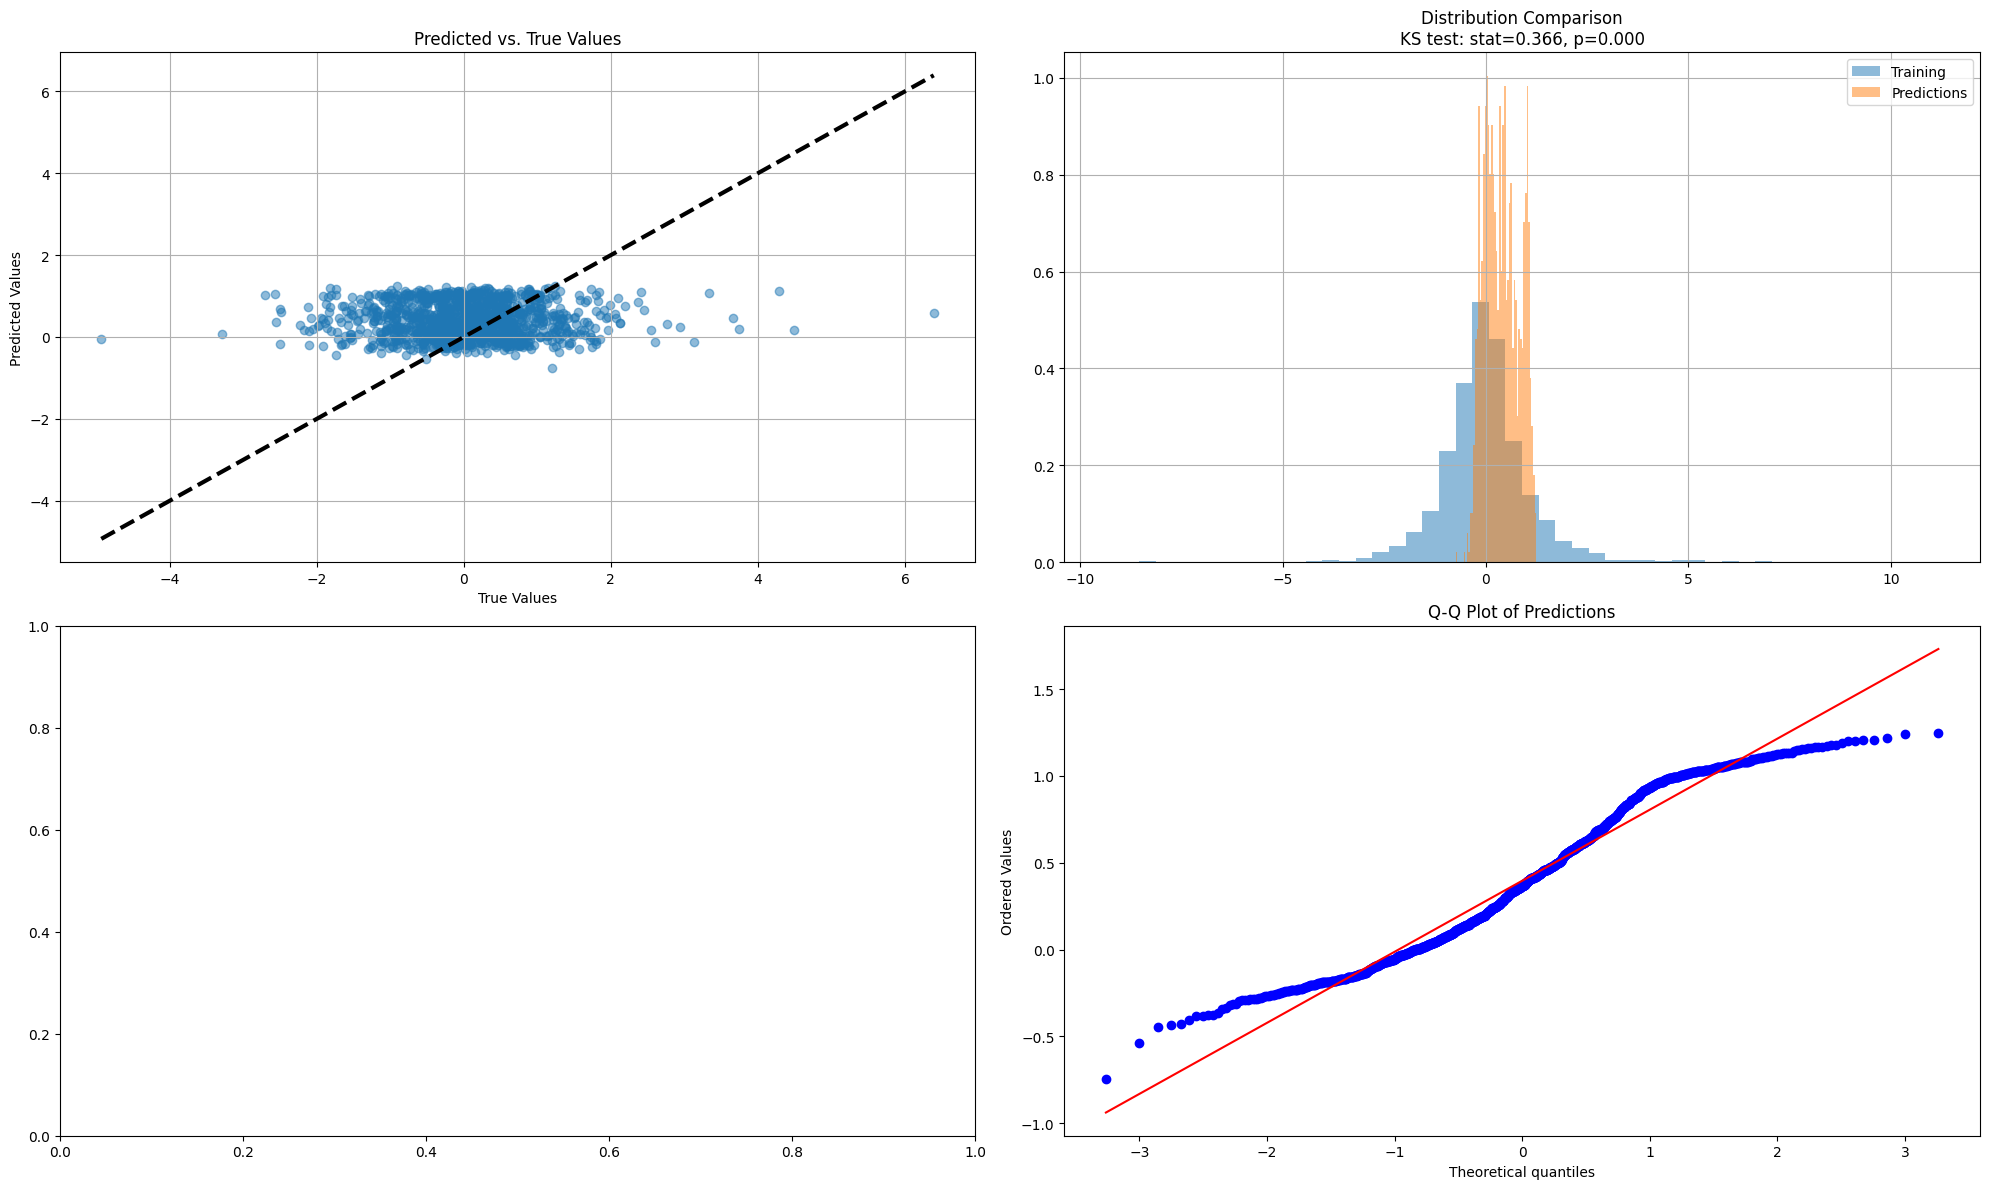

In [5]:
results = evaluate_model_with_distribution(
    best_model,
    X_test_seq,
    y_test_seq,
    train_distribution,
    None
)


Final Model Evaluation:
Test MSE: 1.1054
Test R2: -0.3740


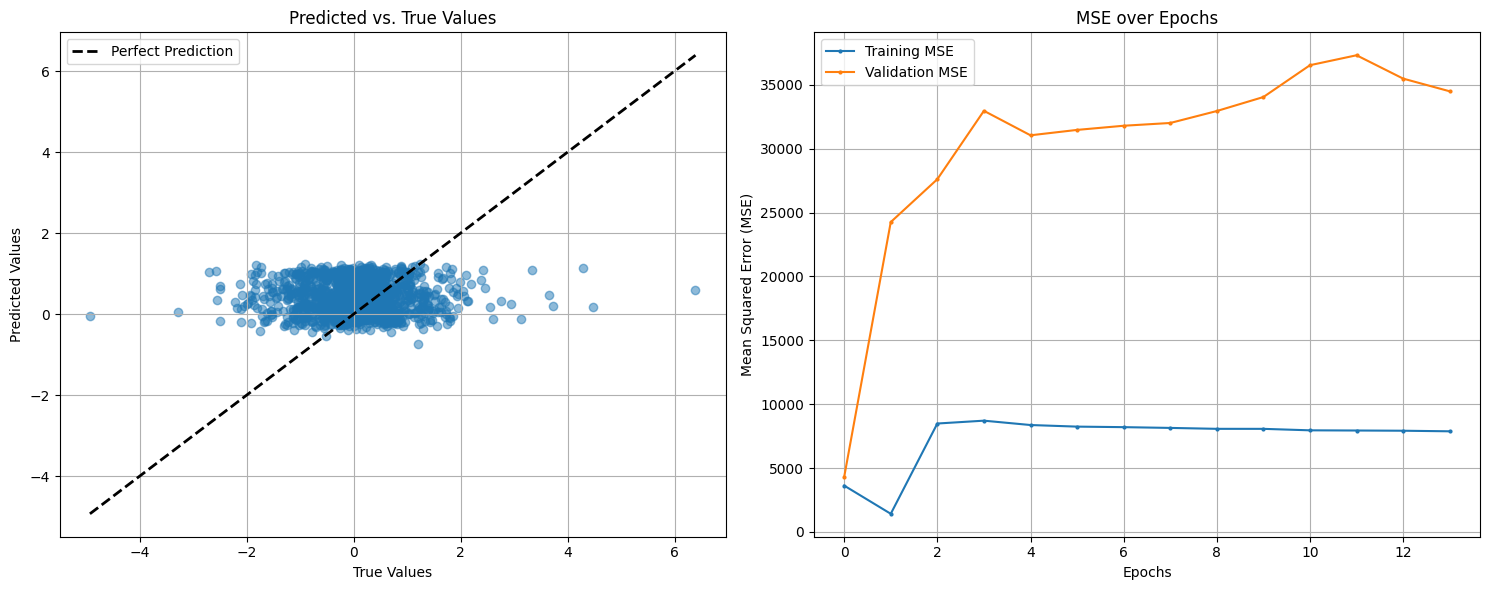


Best Hyperparameters:
batch_size: 128
dropout_rate: 0.1596622834579118
hidden_size: 64
loss_lower_bound: -1.0104842552464084
loss_penalty_weight: 57359.69176484738
loss_upper_bound: 1.2363076724386135
lr: 0.001922911483195667
max_epochs: 500
nonlin: ReLU()
num_layers: 1
seq_length: 10
use_residual: True
weight_decay: 0.018394738702099164


In [6]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Get the best model and its sequence length
best_model = best_trial['result']['model']
best_seq_length = int(best_trial['result']['params']['seq_length'])

# Prepare test data with best sequence length
X_test_seq, y_test_seq = prepare_data(X_test, y_test, best_seq_length)

# Get predictions on test data
y_pred_test = best_model.predict(X_test_seq)

# Calculate metrics
test_mse = mean_squared_error(y_test_seq, y_pred_test)
test_r2 = r2_score(y_test_seq, y_pred_test)

# Print final results
print("\n" + "="*50)
print("Final Model Evaluation:")
print("="*50)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")

# Convert tensors to numpy if needed
y_pred_test = y_pred_test if isinstance(y_pred_test, np.ndarray) else y_pred_test.detach().numpy()
y_test_seq = y_test_seq if isinstance(y_test_seq, np.ndarray) else y_test_seq.detach().numpy()

# Create visualization plots
plt.figure(figsize=(15, 6))

# 1. Scatter plot of predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(y_test_seq, y_pred_test, alpha=0.5)
plt.plot([y_test_seq.min(), y_test_seq.max()], 
         [y_test_seq.min(), y_test_seq.max()], 
         'k--', lw=2, 
         label='Perfect Prediction')
plt.title('Predicted vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

# 2. Training and validation loss curves
plt.subplot(1, 2, 2)
history = best_model.history
train_mse = [h['train_loss'] for h in history]
valid_mse = [h['valid_loss'] for h in history if 'valid_loss' in h]

plt.plot(train_mse, label='Training MSE', marker='o', markersize=2)
plt.plot(valid_mse, label='Validation MSE', marker='o', markersize=2)
plt.title('MSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best hyperparameters again for reference
print("\n" + "="*50)
print("Best Hyperparameters:")
print("="*50)
for param, value in best_trial['result']['params'].items():
    print(f"{param}: {value}")

# Save the best model
net = best_model

In [7]:
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def visualize_hyperopt_results(trials):
    """Visualize hyperopt optimization process with MSE values and log scale"""
    # Create evolution of MSE plot with log scale
    losses = [trial['result']['loss'] for trial in trials.trials]  # These are MSE values
    best_losses = np.minimum.accumulate(losses)
    
    # First plot: MSE evolution over trials
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=losses, name='Trial MSE',
                            mode='markers+lines', marker=dict(size=8)))
    fig.add_trace(go.Scatter(y=best_losses, name='Best MSE',
                            mode='lines', line=dict(width=2)))
    
    fig.update_layout(
        title='Hyperopt Optimization Progress',
        xaxis_title='Trial Number',
        yaxis_title='MSE (log scale)',
        template='plotly_white',
        yaxis_type="log"  # Set y-axis to log scale
    )
    fig.show()
    
    # Parameter importance visualization
    param_values = {}
    param_scores = {}
    
    # Collect all parameter values and scores
    for trial in trials.trials:
        for param, value in trial['result']['params'].items():
            if param not in param_values:
                param_values[param] = []
                param_scores[param] = []
            if not isinstance(value, (nn.Module, bool)):  # Skip non-numeric parameters
                param_values[param].append(float(value))
                param_scores[param].append(trial['result']['loss'])
    
    # Create second plot
    fig = go.Figure()
    
    for param in param_values.keys():
        if param_values[param]:  # Check if we have values for this parameter
            # Normalize only parameter values to 0-1 range
            param_scaler = MinMaxScaler()
            normalized_param_values = param_scaler.fit_transform(np.array(param_values[param]).reshape(-1, 1)).flatten()
            
            # Use actual MSE values (not normalized)
            mse_values = np.array(param_scores[param])
            
            fig.add_trace(go.Scatter(
                x=normalized_param_values,
                y=mse_values,  # Use actual MSE values
                mode='markers',
                name=f"{param}",
                hovertemplate=(
                    f"{param}<br>" +
                    "Normalized Value: %{x:.3f}<br>" +
                    "Original Value: %{customdata[0]:.3f}<br>" +
                    "MSE: %{y:.6f}<br>" +
                    "<extra></extra>"
                ),
                customdata=np.column_stack((
                    param_values[param],
                    mse_values
                ))
            ))
    
    fig.update_layout(
        title='Parameter Impact on MSE',
        xaxis_title='Normalized Parameter Value (0-1)',
        yaxis_title='MSE (log scale)',
        template='plotly_white',
        xaxis=dict(range=[-0.1, 1.1]),  # Add some padding
        yaxis_type="log"  # Set y-axis to log scale
    )
    
    # Add vertical reference line at x=0.5
    fig.add_vline(x=0.5, line_dash="dash", line_color="gray", opacity=0.5)
    
    fig.show()

# Execute the visualization
visualize_hyperopt_results(trials)
#Loog normalize these losses